In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

# Знакомство с данными, обработка и анализ

В данной работе используется следующий набор данных о погоде: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data.

В этот набор данных включены замеры 4 метеорологических показателей (температура воздуха, влажность, скорость ветра и атмосферное давление), выполняющиеся каждый день с 2013 года по 2017. В обучающей выборке присутствуют данные с 2013 года по 2016. В тестовой же выборке данные представлены только за первые четыре месяца 2017 года.

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

Посмотрим на имеющиеся данные.

In [3]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [5]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [6]:
df_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [7]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [8]:
df_test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


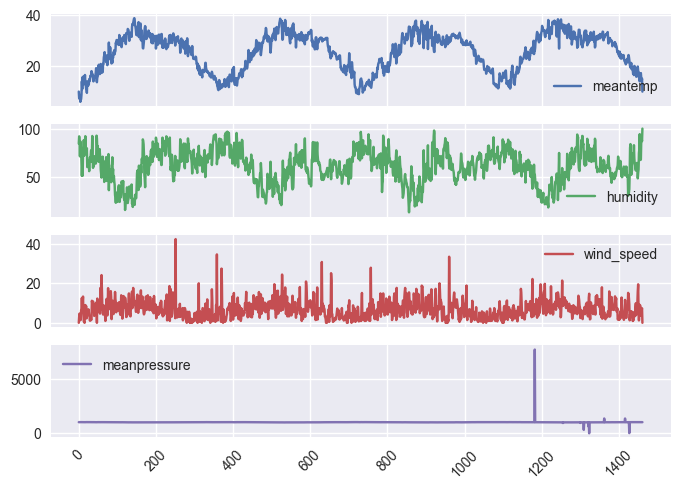

In [9]:
df.plot(subplots=True, rot=45);

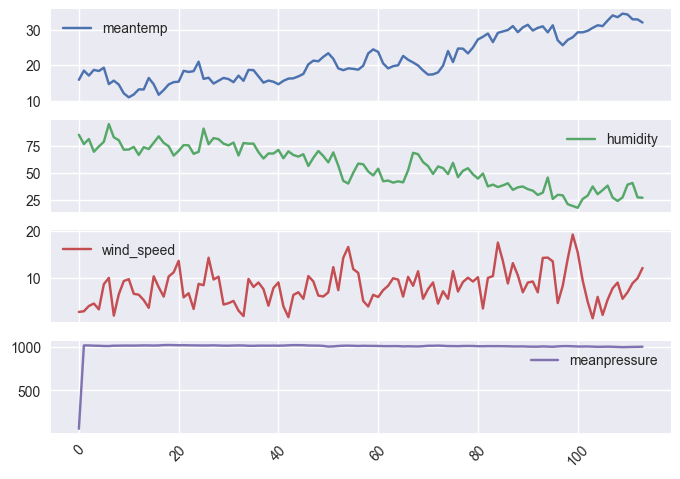

In [10]:
df_test.plot(subplots=True, rot=45);

Видим, что в столбце `meanpressure` присутствуют явные выбросы.

![Диаграмма размаха](./boxplot.png)

При помощи написанной функции `remove_outliers_iqr` удалим выбросы (а точнее заменим их на медианные значения).

In [11]:
def remove_outliers_iqr(data, replacement):
    
    # Вычисляем первый квартиль (25-й перцентиль)
    q1 = np.percentile(data, 25)
    # Вычисляем третий квартиль (75-й перцентиль)
    q3 = np.percentile(data, 75)
    
    # Вычисляем межквартильный размах (IQR)
    iqr = q3 - q1
    
    # Вычисляем нижнюю и верхнюю границы для определения выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Заменяем выбросы на заданное значение
    # np.where проверяет условия: если элемент меньше нижней границы или больше верхней границы, 
    # он заменяется на значение replacement, иначе оставляется без изменений
    replaced_data = np.where((data < lower_bound) | (data > upper_bound), replacement, data)
    
    return replaced_data

In [12]:
meanpressure_without_outliers = remove_outliers_iqr(df['meanpressure'], df['meanpressure'].median())
df['meanpressure'] = meanpressure_without_outliers

meanpressure_test_without_outliers = remove_outliers_iqr(df_test['meanpressure'], df_test['meanpressure'].median())
df_test['meanpressure'] = meanpressure_test_without_outliers

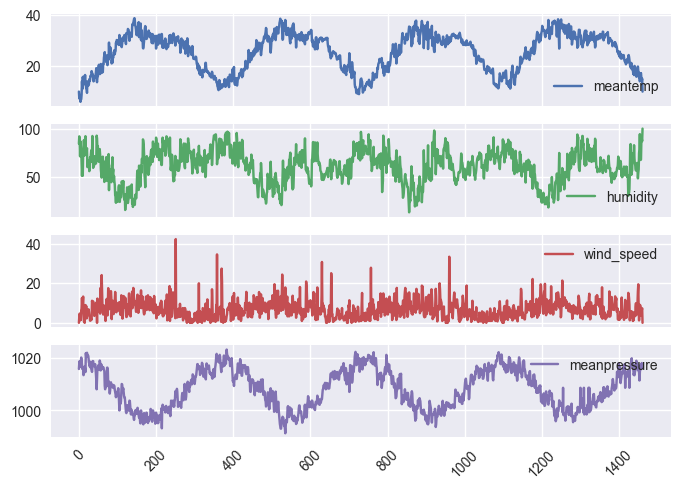

In [13]:
df.plot(subplots=True, rot=45);

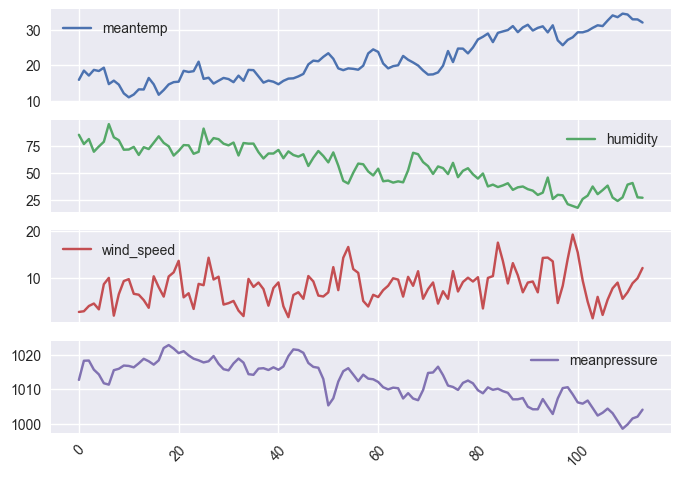

In [14]:
df_test.plot(subplots=True, rot=45);

Теперь выбросы отсутствуют.

Установим столбец `date` в качестве индекса, это позволит в дальнейшем легче выполнить анализ данных.

In [15]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

Выполним ресемплирование временного ряда с ежемесячной частотой.

In [16]:
# Ресемплируем данные df с ежемесячной частотой, используя конец месяца ('ME'), и вычисляем среднее значение для каждого месяца
monthly_resampled_data = df.resample('ME').mean()

In [17]:
# Преобразуем индекс месячных данных в строковый формат 'МММ ГГГГ' (например, 'Jan 2020') для удобного отображения
months = monthly_resampled_data.index.strftime('%b %Y')

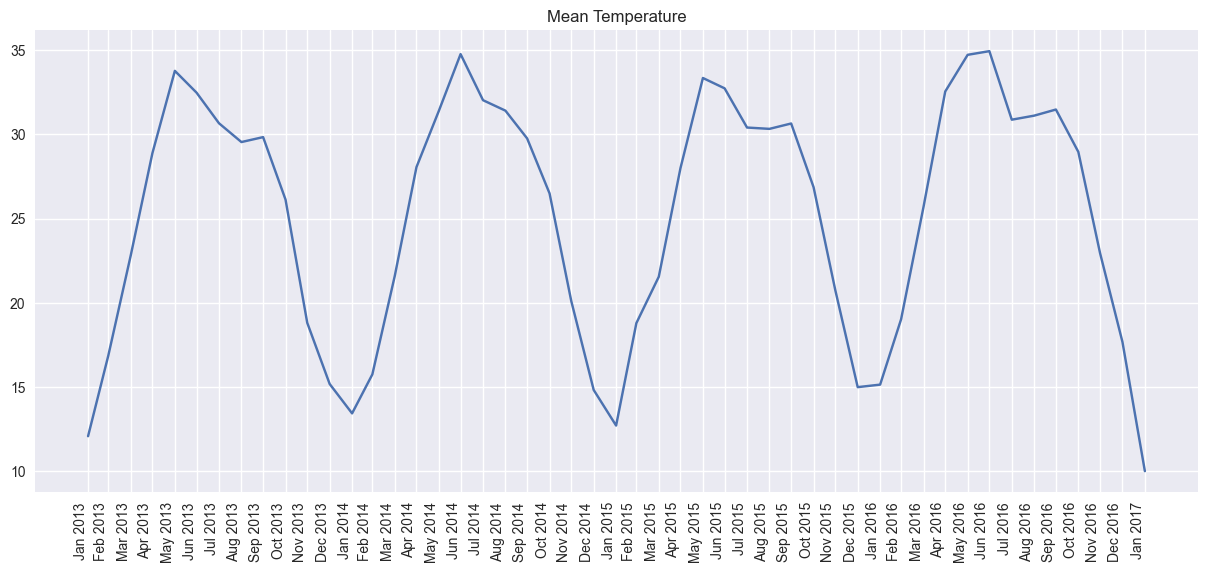

In [18]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])

ax.plot(monthly_resampled_data['meantemp'])
ax.set_xticks(monthly_resampled_data.index)
ax.set_xticklabels(months, rotation=90, ha='right')

plt.title('Mean Temperature');

Выполним сезонное разложение временного ряда средней температуры с помощью функции `seasonal_decompose`. Это разложение разделяет временной ряд на три компоненты:

1. Тренд --- долгосрочное движение данных.
2. Сезонность --- повторяющиеся временные закономерности.
3. Шум (остаток) --- случайные колебания, не объясненные трендом или сезонностью.

In [19]:
decomposed = seasonal_decompose(monthly_resampled_data['meantemp'])

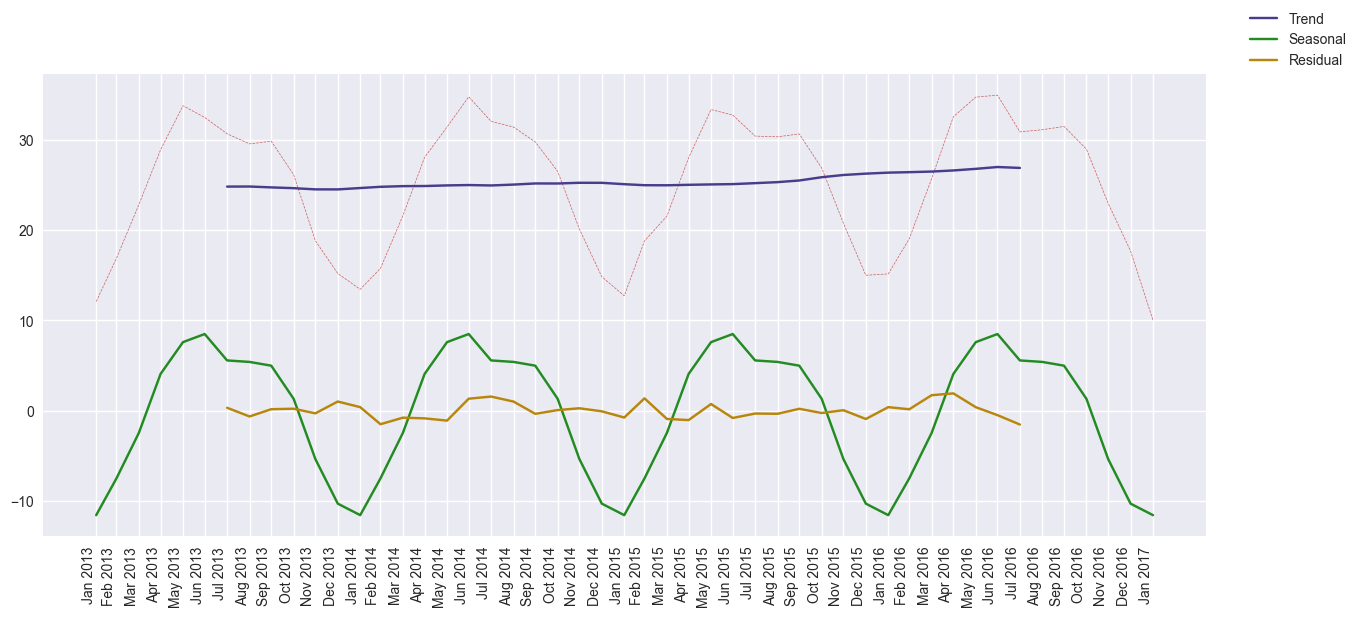

In [20]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])

ax.plot(monthly_resampled_data['meantemp'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_xticks(monthly_resampled_data.index)
ax.set_xticklabels(months, rotation=90, ha='right')

fig.legend();

На графике выше можно заметить небольшой восходящий тренд, что, вероятно, указывает на глобальное потепление. Помимо этого, данные демонстрируют выраженную сезонность: температура ежегодно повышается, достигая своего пика летом, а затем постепенно снижается.

Таким образом, разложение временных рядов на компоненты позволяет глубже анализировать временные ряды. Этот метод помогает понять структуру данных и использовать полученную информацию для различных целей, таких как прогнозирование и принятие решений. Пример с погодой демонстрирует его практическую ценность: мы можем обнаружить долгосрочный тренд глобального потепления и ежегодные сезонные изменения температуры, что важно для климатических исследований. Такой подход можно применить и к другим временным рядам, например, в экономике или здравоохранении, для анализа и улучшения понимания данных.

# Подготовка данных для обучения рекуррентных нейронных сетей (SimpleRNN, LSTM, GRU)

Рекуррентная нейронная сеть (РНС) — это тип нейронных сетей, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.

Рекуррентные нейронные сети принимают на вход последовательность векторов в виде двумерного тензора с формой `(временные_интервалы, входные_признаки)`. Поэтому, если мы хотим обучить нейронную сеть предсказывать температуру на неделю вперед, необходимо создать временные интервалы, содержащие последние 7 наблюдений. Функция `generate_data` возвращает временные интервалы для обучения модели, позволяя использовать различные конфигурации для генерации выборки. Например, можно осуществлять точечное прогнозирование (предсказание одного значения) или интервальное прогнозирование (предсказание нескольких значений одновременно).

In [21]:
def generate_data(dataset, target, start_index, end_index, history_size,
                  target_size, step, single_step=False):
    
    """
    Возвращает временные интервалы для обучения модели.

    Параметры:
    dataset (array-like): Массив данных.
    target (array-like): Массив целевых значений.
    start_index (int): Начальный индекс для генерации данных.
    end_index (int): Конечный индекс для генерации данных.
    history_size (int): Размер последнего временного интервала.
    target_size (int): Аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать.
    step (int): Шаг между временными точками.
    single_step (bool): Флаг для использования одного шага в метках или нескольких.

    Возвращает:
    tuple: Кортеж из двух массивов: данные и метки.
    """
    
    data = []
    labels = []
    
    # Начинаем сдвиг с учетом истории
    start_index += history_size
    # Если end_index не задан, устанавливаем его в конец датасета минус target_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    # Цикл для генерации данных и меток
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) # Индексы для выборки данных
        data.append(dataset[indices]) # Добавляем срез данных в список
        
        if single_step:
            labels.append(target[i+target_size]) # Добавляем метку для одного шага
        else:
            labels.append(target[i:i+target_size]) # Добавляем метки для нескольких шагов
            
    return np.array(data), np.array(labels)

Будем обучать модель, используя только один признак --- температуру.

In [23]:
dataset = df[:-1]['meantemp']
dataset = pd.DataFrame(dataset)
data = dataset.values

dataset_test = df_test['meantemp']
dataset_test = pd.DataFrame(dataset_test)
data_test = dataset_test.values

In [24]:
data.shape

(1461, 1)

In [25]:
data_test.shape

(114, 1)

Разделим выборку на обучающую и валидационную.

In [26]:
train_size = int(len(data) * 0.75)
print('Разделение выборки на обучающую и валидационную:', train_size)

Разделение выборки на обучающую и валидационную: 1095


Перед обучением нейронной сети важным шагом является масштабирование данных. Одним из распространённых способов выполнения масштабирования является стандартизация, выполняемая путём вычитания среднего значения и деления на стандартное отклонение для каждого признака. Стандартизация должна выполняться только с использованием обучающих данных, в противном случае произойдет утечка данных.

Выполним стандартизацию данных.

In [27]:
scaler = StandardScaler()
scaler.fit(np.array(data[:train_size]))

scaled_data = scaler.transform(data)
scaled_data_test = scaler.transform(data_test)

In [63]:
print(f'Стандартное отклонение: {scaler.scale_[0]}')
print(f'Среднее значение: {scaler.mean_[0]}')

Стандартное отклонение: 7.407290195875342
Среднее значение: 24.972252668951906


Будем выполнять точечное прогнозирование температуры воздуха на следующий день, используя данные за последнюю неделю.

In [28]:
# Размер последнего временного интервала
PAST_HISTORY = 7 
# Аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать
FUTURE_TARGET = 0
# Шаг между временными точками
STEP = 1

# Создание обучающей выборки
x_train, y_train = generate_data(scaled_data, scaled_data, 0,
                                 train_size, PAST_HISTORY,
                                 FUTURE_TARGET, STEP,
                                 single_step=True)

# Создание валидационной выборки
x_val, y_val = generate_data(scaled_data, scaled_data, train_size,
                             None, PAST_HISTORY,
                             FUTURE_TARGET, STEP,
                             single_step=True)

# Создание тестовой выборки
x_test, y_test = generate_data(scaled_data_test, scaled_data_test, 0,
                               None, PAST_HISTORY,
                               FUTURE_TARGET, STEP,
                               single_step=True)

In [29]:
print('Размерность обучающей выборки:', x_train.shape)
print('Размерность валидационной выборки:', x_val.shape)
print('Размерность тестовой выборки:', x_test.shape)

Размерность обучающей выборки: (1088, 7, 1)
Размерность валидационной выборки: (359, 7, 1)
Размерность тестовой выборки: (107, 7, 1)


# Обучение рекуррентных нейронных сетей (SimpleRNN, LSTM, GRU) и оценка результатов

Создадим модели рекуррентных нейронных сетей, используя инструменты фреймворка `Keras`.

In [30]:
model_rnn = tf.keras.models.Sequential([
    # Добавляем слой SimpleRNN с 32 единицами (нейронами) и определяем форму входных данных
    tf.keras.layers.SimpleRNN(units=32,
                              input_shape=x_train.shape[-2:]
                              ),
    # Добавляем полносвязный (Dense) слой с 1 единицей для предсказания
    tf.keras.layers.Dense(units=1)
])

model_gru = tf.keras.models.Sequential([
    # Добавляем слой GRU с 32 единицами (нейронами) и определяем форму входных данных
    tf.keras.layers.GRU(units=32,
                        input_shape=x_train.shape[-2:]
                        ),
    # Добавляем полносвязный (Dense) слой с 1 единицей для предсказания
    tf.keras.layers.Dense(units=1)
])

model_lstm = tf.keras.models.Sequential([
    # Добавляем слой LSTM с 32 единицами (нейронами) и определяем форму входных данных
    tf.keras.layers.LSTM(units=32,
                         input_shape=x_train.shape[-2:]
                         ),
    # Добавляем полносвязный (Dense) слой с 1 единицей для предсказания
    tf.keras.layers.Dense(units=1)
])

# Компиляция модели с использованием SimpleRNN
model_rnn.compile(optimizer='adam', loss='mae')

# Компиляция модели с использованием GRU
model_gru.compile(optimizer='adam', loss='mae')

# Компиляция модели с использованием LSTM
model_lstm.compile(optimizer='adam', loss='mae')

Выведем структуры моделей.

In [31]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Будем обучать модели на протяжении 100 эпох, используя валидационную выборку для мониторинга переобучения.

In [34]:
EPOCHS = 100

In [35]:
history_rnn = model_rnn.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3930 - val_loss: 0.2097
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2132 - val_loss: 0.1864
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1842 - val_loss: 0.1714
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1748 - val_loss: 0.1671
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1774 - val_loss: 0.1668
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1697 - val_loss: 0.1655
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1676 - val_loss: 0.1699
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1659 - val_loss: 0.1652
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1645 - val_loss: 0.1647
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1567 - val_loss: 0.1654
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1538 - val_loss: 0.1634
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

Создадим функцию `plot_train_history` для наглядного отображения значений потерь на этапах обучения и валидации.

In [36]:
def plot_train_history(history, title):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
    plt.plot(epochs, val_loss, 'r', label='Потери на этапе валидации')
    plt.title(title)
    plt.legend()
    
    plt.show()

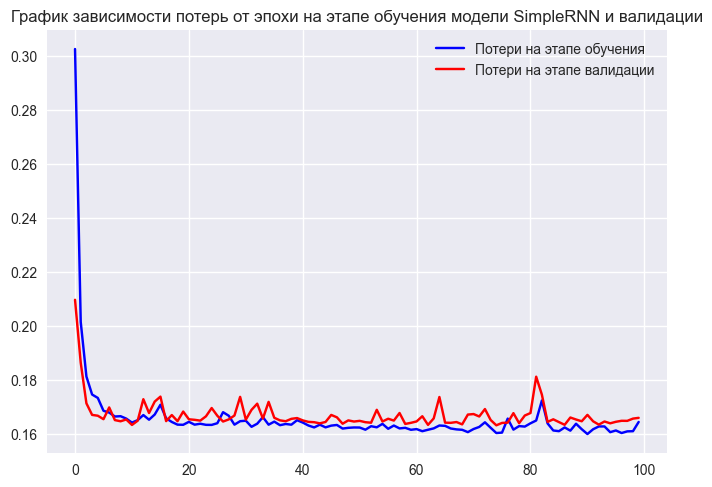

In [37]:
plot_train_history(history_rnn, 'График зависимости потерь от эпохи на этапе обучения модели SimpleRNN и валидации')

Видим, что потери модели SimpleRNN достигли своего минимума, явных признаков переобучения нет, однако присутствуют осцилляции.

Обучим модель GRU.

In [38]:
history_gru = model_gru.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0226 - val_loss: 0.4945
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3792 - val_loss: 0.2076
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2100 - val_loss: 0.2028
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2069 - val_loss: 0.2019
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2041 - val_loss: 0.1959
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2008 - val_loss: 0.1914
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1821 - val_loss: 0.1870
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1970 - val_loss: 0.1875
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1918 - val_loss: 0.1811
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1803 - val_loss: 0.1795
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1752 - val_loss: 0.1758
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

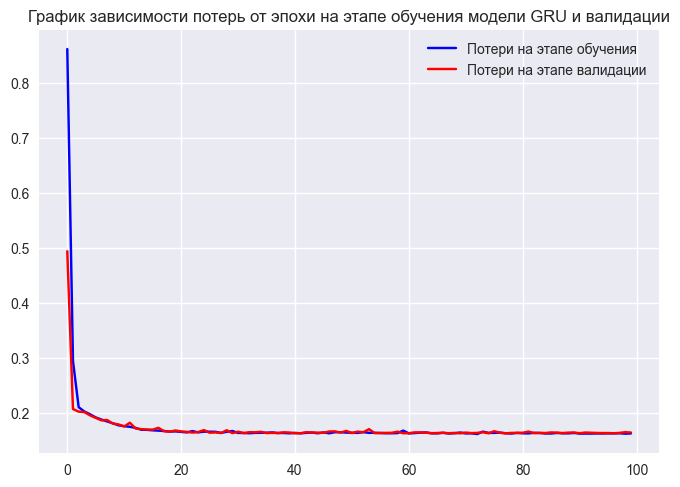

In [39]:
plot_train_history(history_gru, 'График зависимости потерь от эпохи на этапе обучения модели GRU и валидации')

Модель GRU продемонстрировала лучшие результаты по сравнению с простой рекуррентной сетью (SimpleRNN). Потери достигли минимума, признаки переобучения отсутствуют, и колебания практически не наблюдаются.

Теперь обучим сеть LSTM.

In [40]:
history_lstm = model_lstm.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9467 - val_loss: 0.4969
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3590 - val_loss: 0.2266
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2416 - val_loss: 0.2262
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2203 - val_loss: 0.2221
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2242 - val_loss: 0.2156
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2273 - val_loss: 0.2117
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2155 - val_loss: 0.2093
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2125 - val_loss: 0.2069
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2060 - val_loss: 0.2035
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1991 - val_loss: 0.2029
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2058 - val_loss: 0.1977
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

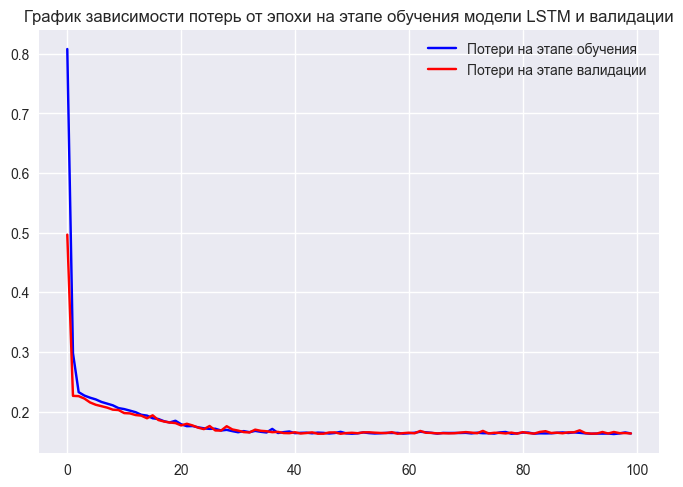

In [41]:
plot_train_history(history_lstm, 'График зависимости потерь от эпохи на этапе обучения модели LSTM и валидации')

LSTM демонстрирует схожие с GRU результаты.

Теперь оценим метрики качества полученных моделей, сгенерировав предсказания для тестового набора данных.

In [ ]:
# Генерация предсказаний для модели SimpleRNN
predictions_rnn = model_rnn.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_rnn = scaler.inverse_transform(predictions_rnn)

# Генерация предсказаний для модели GRU
predictions_gru = model_gru.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_gru = scaler.inverse_transform(predictions_gru)

# Генерация предсказаний для модели LSTM
predictions_lstm = model_lstm.predict(x_test, verbose=0)
# Обратное преобразование масштабированных предсказаний в исходные значения
predictions_lstm = scaler.inverse_transform(predictions_lstm)

In [43]:
# Обратное преобразование масштабированных тестовых значений в исходные значения
y_test = scaler.inverse_transform(y_test)

In [44]:
# Создание DataFrame с предсказаниями и фактическими значениями для модели SimpleRNN
preds_acts_rnn = pd.DataFrame(data={'Predictions':predictions_rnn.flatten(), 'Actuals':y_test.flatten()})

# Создание DataFrame с предсказаниями и фактическими значениями для модели GRU
preds_acts_gru = pd.DataFrame(data={'Predictions':predictions_gru.flatten(), 'Actuals':y_test.flatten()})

# Создание DataFrame с предсказаниями и фактическими значениями для модели LSTM
preds_acts_lstm = pd.DataFrame(data={'Predictions':predictions_lstm.flatten(), 'Actuals':y_test.flatten()})

In [45]:
preds_acts_rnn

,Predictions,Actuals
0,15.099424,15.684211
1,15.610086,14.571429
2,14.771909,12.111111
3,12.168304,11.000000
4,11.593743,11.789474
...,...,...
102,33.334957,34.500000
103,34.319725,34.250000
104,34.236553,32.900000
105,33.062504,32.875000


In [46]:
preds_acts_gru

,Predictions,Actuals
0,15.264335,15.684211
1,16.114912,14.571429
2,15.075852,12.111111
3,12.869837,11.000000
4,11.842702,11.789474
...,...,...
102,33.073944,34.500000
103,34.035637,34.250000
104,33.860188,32.900000
105,32.841545,32.875000


In [47]:
preds_acts_lstm

,Predictions,Actuals
0,15.107856,15.684211
1,15.828211,14.571429
2,14.747776,12.111111
3,12.619109,11.000000
4,11.517486,11.789474
...,...,...
102,33.090931,34.500000
103,34.059204,34.250000
104,33.874538,32.900000
105,32.893089,32.875000


Создадим функцию `visualize_predictions` для отображения предсказаний и фактических значений, а также для вычисления метрики средней абсолютной ошибки (MAE, Mean Absolute Error).

$$MAE = \sum_{i=1}^{D}|x_i-y_i|$$

In [48]:
def visualize_predictions(preds_acts):
    
    MAE = np.mean(np.abs(preds_acts['Actuals'] - preds_acts['Predictions'])).round(5)
    
    plt.figure(figsize = (16, 6))
    
    plt.plot(preds_acts['Predictions'], 'r')
    plt.plot(preds_acts['Actuals'], 'g')
    
    plt.legend([f'Predictions (MAE = {MAE} °С)', 'Actuals'], fontsize=20)
    plt.show()

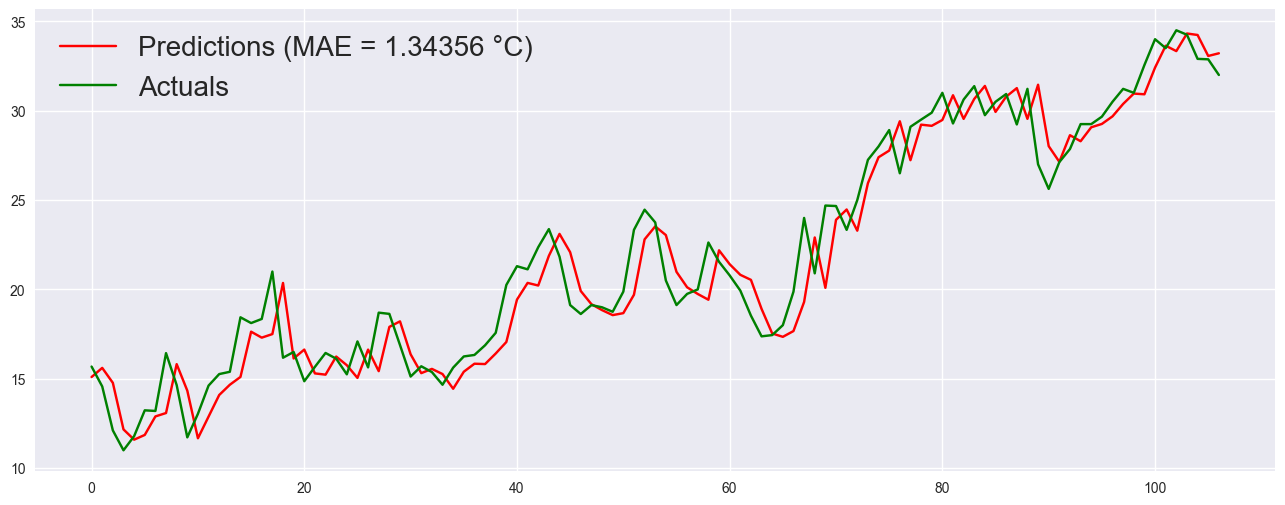

In [49]:
visualize_predictions(preds_acts_rnn)

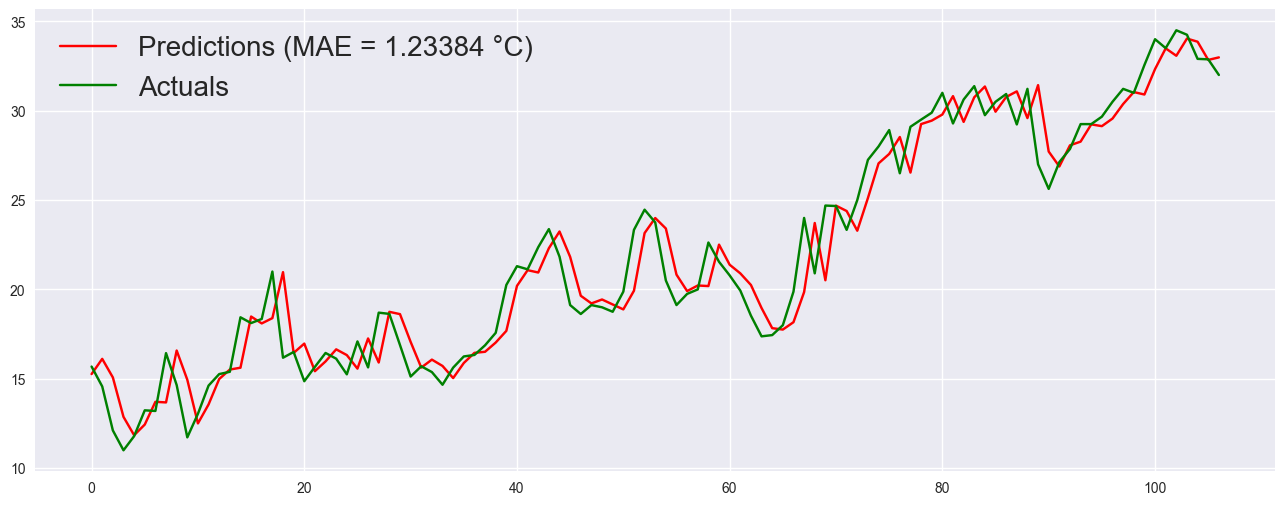

In [50]:
visualize_predictions(preds_acts_gru)

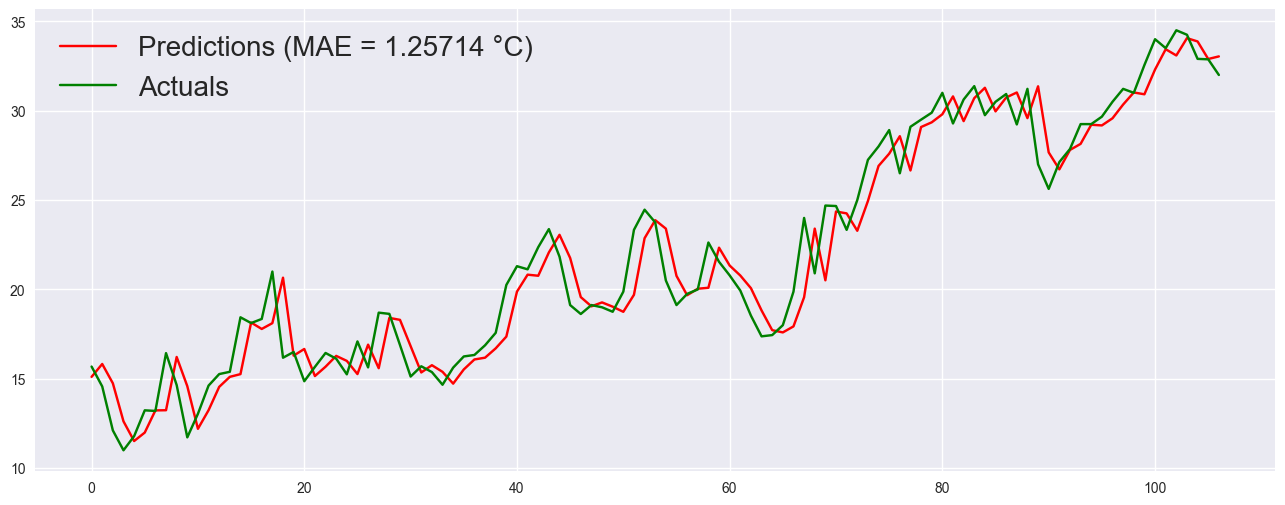

In [51]:
visualize_predictions(preds_acts_lstm)

# Вывод

Видим, что для задачи прогнозирования температуры на следующий день наилучшие результаты показала рекуррентная нейронная сеть GRU, достигнув метрики MAE всего в 1.23°C. Это означает, что среднее отклонение предсказанных значений температуры от фактических составляет около 1.23°C, что является достаточно хорошим результатом.

Модели SimpleRNN и LSTM также показали неплохие результаты, но их метрики качества были несколько хуже. SimpleRNN может быть полезна благодаря наименьшему числу обучаемых параметров, что делает ее обучение быстрее. Однако это преимущество достигается за счет качества предсказаний.

Модель LSTM показала худшие результаты по сравнению с GRU, несмотря на свою более сложную архитектуру и большее количество обучаемых параметров. Использование модели LSTM в данной задаче нецелесообразно, поскольку она не только усложняет процесс обучения, но и уступает GRU по качеству предсказаний. Стоит отметить, что GRU была разработана как упрощенная и улучшенная версия LSTM, что позволяет ей сохранять высокое качество предсказаний при меньшей сложности.

Таким образом, модель GRU является оптимальным выбором для этой задачи, так как она демонстрирует хорошие результаты и обладает разумным количеством обучаемых параметров.